In [11]:
import sys
print(sys.executable)

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import netCDF4 as nc
from netCDF4 import Dataset
import xarray as xr
from scipy.io import loadmat
from datetime import datetime, timedelta

c:\Users\funkb\Documents\Python\venv\Scripts\python.exe


In [12]:
years = range(1990, 2024)
columns = ['datetime','tm2','precip']
df = pd.DataFrame(columns=columns)

all_matlab_data = loadmat(r'C:\Users\funkb\Documents\MATLAB\Research\data\Synthesis\CRplotdata.mat')
print(all_matlab_data.keys())
all_flow_vector = all_matlab_data['allflows']
all_flow_dt_vector = all_matlab_data['alldatenum']
print(all_flow_vector.shape)
print(all_flow_dt_vector.shape)
print(all_flow_dt_vector[0:5])
print(type(all_flow_dt_vector))

dict_keys(['__header__', '__version__', '__globals__', 'CRmonthlymean', 'alldatenum', 'allflows', 'ci_high', 'ci_low', 'cruiseduration2019logic', 'cruiseduration2020logic', 'daynums', 'doy', 'firstdayofmonth_indays', 'logic2019', 'logic2020'])
(6793, 1)
(6793, 1)
[[726834]
 [726835]
 [726836]
 [726837]
 [726838]]
<class 'numpy.ndarray'>


In [13]:
def matlab_datenum_to_datetime(datenum):
    # MATLAB datenum is days since 0000-01-00
    # Python datetime uses 0001-01-01, so subtract 366 days
    return [datetime.fromordinal(int(d[0])) + timedelta(days=float(d[0])%1) - timedelta(days=366) for d in datenum]


flow_dt = matlab_datenum_to_datetime(all_flow_dt_vector)
print(flow_dt[:5])

all_dt = []
all_t2m = []
all_precip = []

[datetime.datetime(1990, 1, 1, 0, 0), datetime.datetime(1990, 1, 2, 0, 0), datetime.datetime(1990, 1, 3, 0, 0), datetime.datetime(1990, 1, 4, 0, 0), datetime.datetime(1990, 1, 5, 0, 0)]


In [17]:
root='C:\\Users\\funkb\\Documents\\Python'

for y in years:
    ds = Dataset(f'{root}/era5land_precip_t2m_{y}_real.nc', 'r')
    print(ds.variables.keys())  # List all variables
    # Convert ERA5 'valid_time' (seconds since 1970-01-01) to pandas datetime
    data_dt = pd.to_datetime(ds.variables['valid_time'][:], unit='s', origin='unix')
    data_t2m = np.mean(ds.variables['t2m'][:], axis=(1,2)) - 273.15  # Convert from Kelvin to Celsius
    data_precip = np.mean(ds.variables['tp'][:], axis=(1,2)) 
    all_dt.append(data_dt)
    all_t2m.append(data_t2m)
    all_precip.append(data_precip)

all_dt_vector = np.concatenate(all_dt)  
all_t2m_vector = np.concatenate(all_t2m)
all_precip_vector = np.concatenate(all_precip)

dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m', 'tp'])
dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m', 'tp'])
dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m', 'tp'])
dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m', 'tp'])
dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m', 'tp'])
dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m', 'tp'])
dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m', 'tp'])
dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m', 'tp'])
dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m', 'tp'])
dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m', 'tp'])
dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m', 'tp'])
dict_keys(['number', 'valid_time', 'latitude', 'longitude', 'expver', 't2m',

In [ ]:
## New cell: Plot confidence intervals for daily mean air temperature, precipitation, and flow, with 2019 and 2020 overlaid (June 23 to July 14) and gap-filled missing days
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Convert all_dt_vector to pandas Series for easier filtering
dt_series = pd.Series(all_dt_vector)
t2m_series = pd.Series(all_t2m_vector)
precip_series = pd.Series(all_precip_vector)
flow_series = pd.Series(np.ravel(all_flow_vector))

# Restrict to June 23 to July 14 for all years
start_day = (6, 23)
end_day = (7, 14)

def is_in_window(dt):
    return ((dt.month == 6 and dt.day >= 23) or (dt.month == 7 and dt.day <= 14))

window_mask = dt_series.apply(is_in_window)
dt_window = dt_series[window_mask]
t2m_window = t2m_series[window_mask]
precip_window = precip_series[window_mask]

# For flow, restrict to same window using flow_dt (already converted to datetime)
flow_dt_series = pd.Series(flow_dt)
flow_window_mask = flow_dt_series.apply(is_in_window)
flow_dt_window = flow_dt_series[flow_window_mask]
flow_window = flow_series[flow_window_mask].reset_index(drop=True)
flow_window = np.ravel(flow_window)

# Group by day-of-year and calculate daily mean and confidence intervals (all years)
df_window = pd.DataFrame({'date': dt_window, 't2m': t2m_window, 'precip': precip_window})
df_window['year'] = df_window['date'].dt.year
df_window['doy'] = df_window['date'].dt.dayofyear

df_flow_window = pd.DataFrame({'date': flow_dt_window, 'flow': flow_window})
df_flow_window['year'] = df_flow_window['date'].dt.year
df_flow_window['doy'] = df_flow_window['date'].dt.dayofyear

# Calculate CI including all years
df_ci = df_window.copy()
ci_t2m = df_ci.groupby('doy')['t2m'].agg(['mean', 'std', 'count'])
ci_precip = df_ci.groupby('doy')['precip'].agg(['mean', 'std', 'count'])
ci_t2m['sem'] = ci_t2m['std'] / np.sqrt(ci_t2m['count'])
ci_precip['sem'] = ci_precip['std'] / np.sqrt(ci_precip['count'])
ci_t2m['ci_upper'] = ci_t2m['mean'] + 1.96 * ci_t2m['sem']
ci_t2m['ci_lower'] = ci_t2m['mean'] - 1.96 * ci_t2m['sem']
ci_precip['ci_upper'] = ci_precip['mean'] + 1.96 * ci_precip['sem']
ci_precip['ci_lower'] = ci_precip['mean'] - 1.96 * ci_precip['sem']

# Flow CI
ci_flow = df_flow_window.groupby('doy')['flow'].agg(['mean', 'std', 'count'])
ci_flow['sem'] = ci_flow['std'] / np.sqrt(ci_flow['count'])
ci_flow['ci_upper'] = ci_flow['mean'] + 1.96 * ci_flow['sem']
ci_flow['ci_lower'] = ci_flow['mean'] - 1.96 * ci_flow['sem']

# Get 2019 and 2020 data
df_2019 = df_window[df_window['year'] == 2019].set_index('doy')
df_2020 = df_window[df_window['year'] == 2020].set_index('doy')
df_flow_2019 = df_flow_window[df_flow_window['year'] == 2019].set_index('doy')
df_flow_2020 = df_flow_window[df_flow_window['year'] == 2020].set_index('doy')

# Gap fill missing days for 2019 and 2020 (forward fill then backward fill)
all_doys = np.arange(dt_window.dt.dayofyear.min(), dt_window.dt.dayofyear.max()+1)
df_2019 = df_2019.reindex(all_doys).ffill().bfill()
df_2020 = df_2020.reindex(all_doys).ffill().bfill()
df_flow_2019 = df_flow_2019.reindex(all_doys).ffill().bfill()
df_flow_2020 = df_flow_2020.reindex(all_doys).ffill().bfill()

# Prepare x-axis labels (month-day) with unique mapping for each day in window
unique_days = [datetime.strptime(f'{dt_window.iloc[0].year} {doy}', '%Y %j').date() for doy in all_doys]
xticks = list(all_doys)
xtick_labels = [d.strftime('%b %d') for d in unique_days]

# Plot
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

# Air temperature
ax1.plot(ci_t2m.index, ci_t2m['mean'], color='tab:blue', label='Daily Mean (All Years)')
ax1.fill_between(ci_t2m.index, ci_t2m['ci_lower'], ci_t2m['ci_upper'], color='tab:blue', alpha=0.2, label='95% CI')
ax1.plot(df_2019.index, df_2019['t2m'], color='tab:orange', marker='o', linestyle='-', label='2019')
ax1.plot(df_2020.index, df_2020['t2m'], color='tab:red', marker='o', linestyle='-', label='2020')
ax1.set_ylabel('Air Temperature (°C)')
ax1.set_title('Daily Mean Air Temperature (June 23 - July 14)')
ax1.legend()
ax1.axvline(184, color='gray', linestyle='--', linewidth=1)
ax1.axvline(189, color='gray', linestyle='--', linewidth=1)

# Precipitation
ax2.plot(ci_precip.index, ci_precip['mean'], color='tab:green', label='Daily Mean (All Years)')
ax2.fill_between(ci_precip.index, ci_precip['ci_lower'], ci_precip['ci_upper'], color='tab:green', alpha=0.2, label='95% CI')
ax2.plot(df_2019.index, df_2019['precip'], color='tab:orange', marker='o', linestyle='-', label='2019')
ax2.plot(df_2020.index, df_2020['precip'], color='tab:red', marker='o', linestyle='-', label='2020')
ax2.set_ylabel('Precipitation (m)')
ax2.set_title('Daily Mean Precipitation (June 23 - July 14)')
ax2.legend()
ax2.axvline(184, color='gray', linestyle='--', linewidth=1)
ax2.axvline(189, color='gray', linestyle='--', linewidth=1)

# Flow
ax3.plot(ci_flow.index, ci_flow['mean'], color='tab:purple', label='Daily Mean (All Years)')
ax3.fill_between(ci_flow.index, ci_flow['ci_lower'], ci_flow['ci_upper'], color='tab:purple', alpha=0.2, label='95% CI')
ax3.plot(df_flow_2019.index, df_flow_2019['flow'], color='tab:orange', marker='o', linestyle='-', label='2019')
ax3.plot(df_flow_2020.index, df_flow_2020['flow'], color='tab:red', marker='o', linestyle='-', label='2020')
ax3.set_ylabel('River Discharge (m³/s)')
ax3.set_title('Daily Mean River Discharge (June 23 - July 14)')
ax3.legend()
ax3.axvline(184, color='gray', linestyle='--', linewidth=1)
ax3.axvline(189, color='gray', linestyle='--', linewidth=1)

# Set x-axis ticks and labels
ax3.set_xticks(xticks)
ax3.set_xticklabels(xtick_labels, rotation=45)

plt.xlabel('Date')
plt.tight_layout()
plt.show()

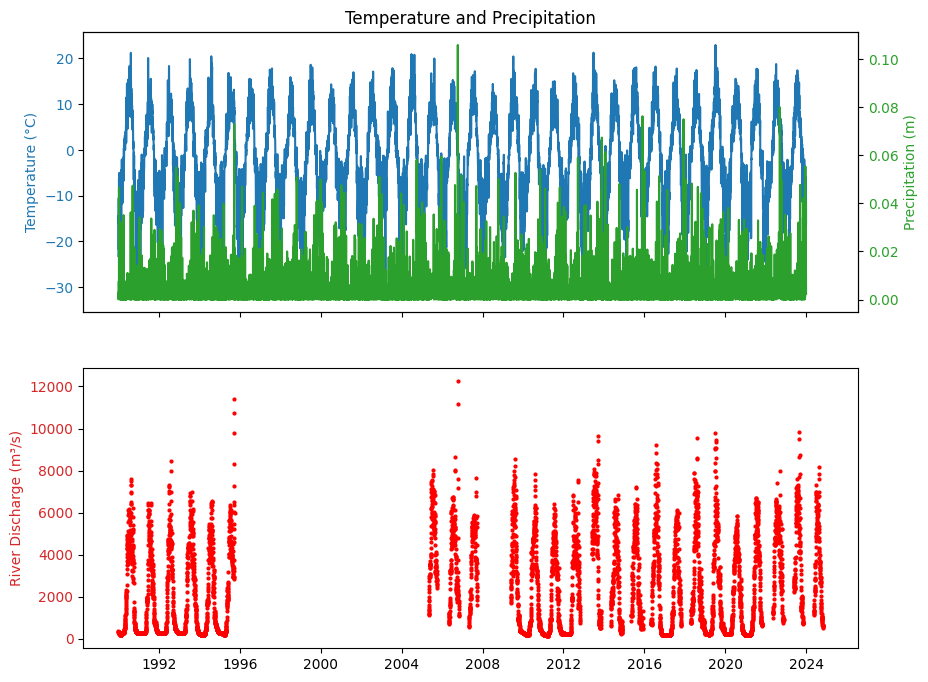

In [ ]:
fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8), sharex=True)

ax1.plot(all_dt_vector,all_t2m_vector, color='tab:blue')
ax1.set_ylabel('Temperature (°C)', color='tab:blue')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax1b = ax1.twinx()
ax1b.plot(all_dt_vector,all_precip_vector, color='tab:green')
ax1b.set_ylabel('Precipitation (m)', color='tab:green')
ax1b.tick_params(axis='y', labelcolor='tab:green')

ax2.plot(flow_dt, all_flow_vector, 'ro', markersize=2, label='River Discharge')
ax2.set_ylabel('River Discharge (m³/s)', color='tab:red')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title("Temperature and Precipitation")
plt.show()

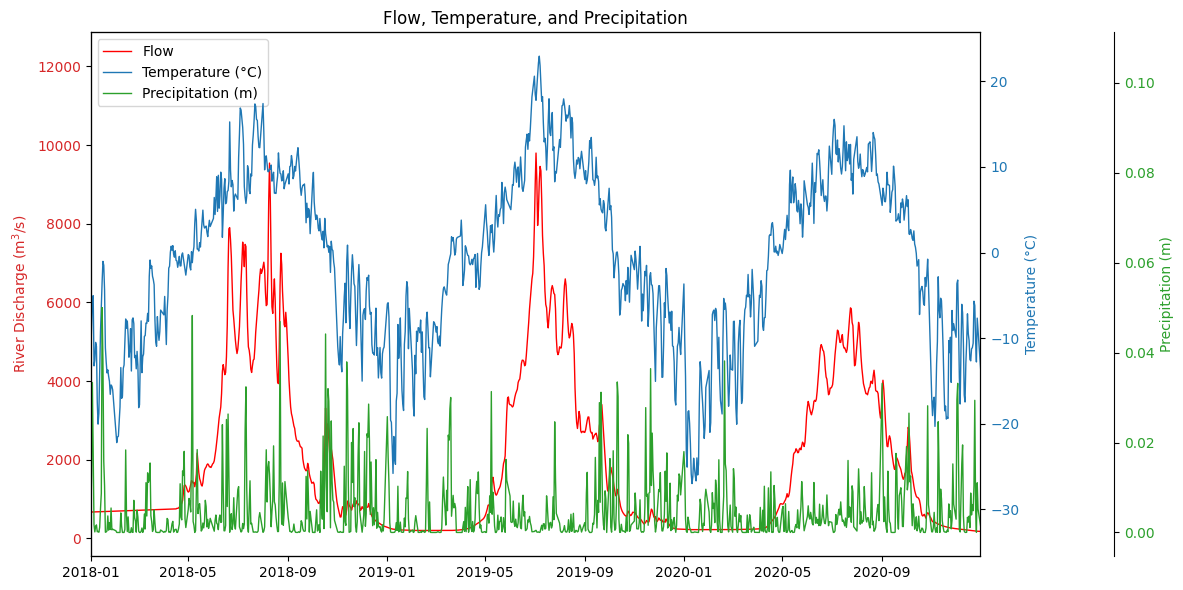

{'cells': [{'cell_type': 'code',
   'id': '#VSC-6a4011a9',
   'metadata': {'language': 'python'},
   'source': ['import sys',
    'print(sys.executable)',
    '',
    'import matplotlib.pyplot as plt',
    'import numpy as np',
    'import pandas as pd',
    'import seaborn as sns',
    'import netCDF4 as nc',
    'from netCDF4 import Dataset',
    'import xarray as xr',
    'from scipy.io import loadmat',
    'from datetime import datetime, timedelta']},
  {'cell_type': 'code',
   'id': '#VSC-5e445988',
   'metadata': {'language': 'python'},
   'source': ['years = range(1990, 2024)',
    "columns = ['datetime','tm2','precip']",
    'df = pd.DataFrame(columns=columns)',
    '',
    "all_matlab_data = loadmat(r'C:\\Users\\funkb\\Documents\\MATLAB\\Research\\data\\Synthesis\\CRplotdata.mat')",
    'print(all_matlab_data.keys())',
    "all_flow_vector = all_matlab_data['allflows']",
    "all_flow_dt_vector = all_matlab_data['alldatenum']",
    'print(all_flow_vector.shape)',
    'print(al

In [29]:
## New cell: Plot flow (left), temperature and precipitation (right, double axis)
import matplotlib.pyplot as plt
fig, ax_flow = plt.subplots(figsize=(12, 6))

# Plot flow on left y-axis
lns1 = ax_flow.plot(flow_dt, all_flow_vector, 'r-', label='Flow', linewidth=1)
ax_flow.set_ylabel('River Discharge (m$^3$/s)', color='tab:red')
ax_flow.tick_params(axis='y', labelcolor='tab:red')
ax_flow.set_xlim(datetime(2018,1,1),datetime(2020,12,31))

# Create first right y-axis for temperature
ax_temp = ax_flow.twinx()
lns2 = ax_temp.plot(all_dt_vector, all_t2m_vector, color='tab:blue', label='Temperature (°C)', linewidth=1)
ax_temp.set_ylabel('Temperature (°C)', color='tab:blue')
ax_temp.tick_params(axis='y', labelcolor='tab:blue')
ax_temp.set_xlim(datetime(2018,1,1),datetime(2020,12,31))

# Create second right y-axis for precipitation
ax_precip = ax_flow.twinx()
# Offset the third axis to the right
ax_precip.spines["right"].set_position(("axes", 1.15))
lns3 = ax_precip.plot(all_dt_vector, all_precip_vector, color='tab:green', label='Precipitation (m)', linewidth=1)
ax_precip.set_ylabel('Precipitation (m)', color='tab:green')
ax_precip.tick_params(axis='y', labelcolor='tab:green')
ax_precip.set_xlim(datetime(2018,1,1),datetime(2020,12,31))

# Combine all legends
lns = lns1 + lns2 + lns3
labels = [l.get_label() for l in lns]
ax_flow.legend(lns, labels, loc='upper left')

plt.title('Flow, Temperature, and Precipitation')
plt.xlabel('Date')
plt.tight_layout()
plt.show()
{
    "cells": [
        {
            "cell_type": "code",
            "id": "#VSC-6a4011a9",
            "metadata": {
                "language": "python"
            },
            "source": [
                "import sys",
                "print(sys.executable)",
                "",
                "import matplotlib.pyplot as plt",
                "import numpy as np",
                "import pandas as pd",
                "import seaborn as sns",
                "import netCDF4 as nc",
                "from netCDF4 import Dataset",
                "import xarray as xr",
                "from scipy.io import loadmat",
                "from datetime import datetime, timedelta"
            ]
        },
        {
            "cell_type": "code",
            "id": "#VSC-5e445988",
            "metadata": {
                "language": "python"
            },
            "source": [
                "years = range(1990, 2024)",
                "columns = ['datetime','tm2','precip']",
                "df = pd.DataFrame(columns=columns)",
                "",
                "all_matlab_data = loadmat(r'C:\\Users\\funkb\\Documents\\MATLAB\\Research\\data\\Synthesis\\CRplotdata.mat')",
                "print(all_matlab_data.keys())",
                "all_flow_vector = all_matlab_data['allflows']",
                "all_flow_dt_vector = all_matlab_data['alldatenum']",
                "print(all_flow_vector.shape)",
                "print(all_flow_dt_vector.shape)",
                "print(all_flow_dt_vector[0:5])",
                "print(type(all_flow_dt_vector))"
            ]
        },
        {
            "cell_type": "code",
            "id": "#VSC-d62cba51",
            "metadata": {
                "language": "python"
            },
            "source": [
                "def matlab_datenum_to_datetime(datenum):",
                "    # MATLAB datenum is days since 0000-01-00",
                "    # Python datetime uses 0001-01-01, so subtract 366 days",
                "    return [datetime.fromordinal(int(d[0])) + timedelta(days=float(d[0])%1) - timedelta(days=366) for d in datenum]",
                "",
                "",
                "flow_dt = matlab_datenum_to_datetime(all_flow_dt_vector)",
                "print(flow_dt[:5])",
                "",
                "all_dt = []",
                "all_t2m = []",
                "all_precip = []"
            ]
        },
        {
            "cell_type": "code",
            "id": "#VSC-cd2c05f8",
            "metadata": {
                "language": "python"
            },
            "source": [
                "root='C:\\\\Users\\\\funkb\\\\Documents\\\\Python'",
                "",
                "for y in years:",
                "    ds = Dataset(f'{root}/era5land_precip_t2m_{y}_real.nc', 'r')",
                "    print(ds.variables.keys())  # List all variables",
                "    # Convert ERA5 'valid_time' (seconds since 1970-01-01) to pandas datetime",
                "    data_dt = pd.to_datetime(ds.variables['valid_time'][:], unit='s', origin='unix')",
                "    data_t2m = np.mean(ds.variables['t2m'][:], axis=(1,2)) - 273.15  # Convert from Kelvin to Celsius",
                "    data_precip = np.mean(ds.variables['tp'][:], axis=(1,2)) ",
                "    all_dt.append(data_dt)",
                "    all_t2m.append(data_t2m)",
                "    all_precip.append(data_precip)",
                "",
                "all_dt_vector = np.concatenate(all_dt)  ",
                "all_t2m_vector = np.concatenate(all_t2m)",
                "all_precip_vector = np.concatenate(all_precip)"
            ]
        },
        {
            "cell_type": "code",
            "id": "#VSC-c477ac1a",
            "metadata": {
                "language": "python"
            },
            "source": [
                "fig, (ax1, ax2) = plt.subplots(2,1, figsize=(10,8), sharex=True)",
                "",
                "ax1.plot(all_dt_vector,all_t2m_vector, color='tab:blue')",
                "ax1.set_ylabel('Temperature (°C)', color='tab:blue')",
                "ax1.tick_params(axis='y', labelcolor='tab:blue')",
                "",
                "ax1b = ax1.twinx()",
                "ax1b.plot(all_dt_vector,all_precip_vector, color='tab:green')",
                "ax1b.set_ylabel('Precipitation (m)', color='tab:green')",
                "ax1b.tick_params(axis='y', labelcolor='tab:green')",
                "",
                "ax2.plot(flow_dt, all_flow_vector, 'ro', markersize=2, label='River Discharge')",
                "ax2.set_ylabel('River Discharge (m³/s)', color='tab:red')",
                "ax2.tick_params(axis='y', labelcolor='tab:red')",
                "",
                "plt.title(\"Temperature and Precipitation\")",
                "plt.show()"
            ]
        }
    ]
}

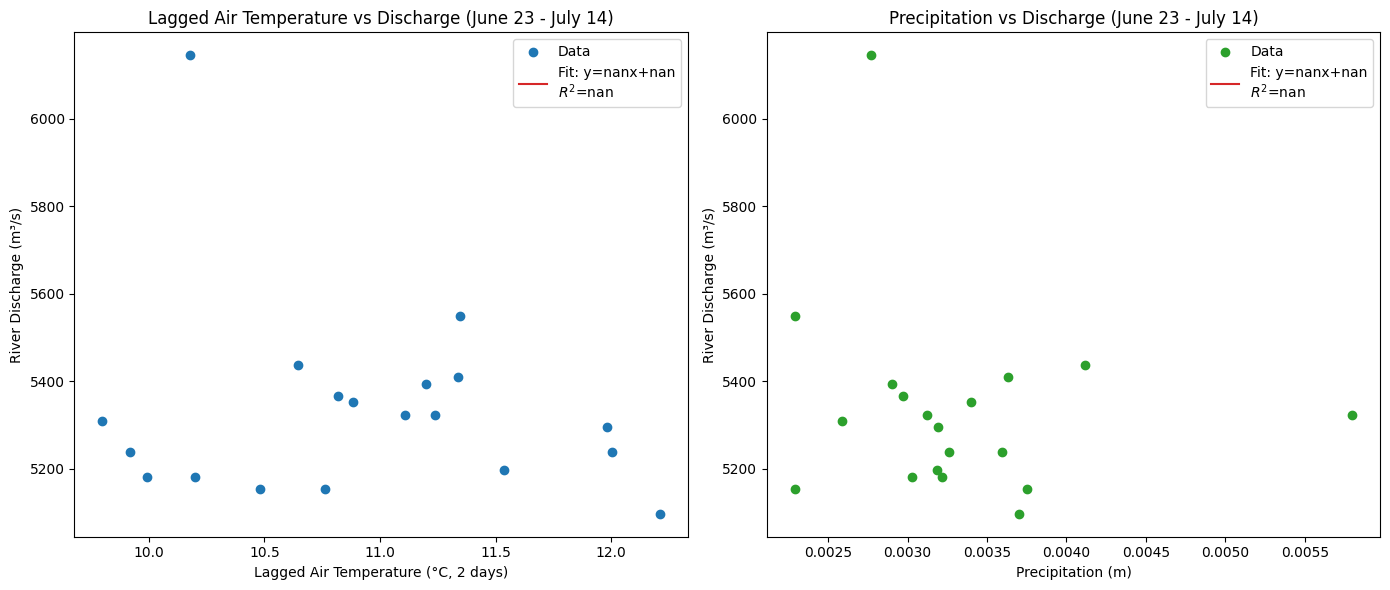

In [41]:
## New cell: Linear regression between lagged air temperature (2 days) & discharge, and precipitation & discharge (June 23 - July 14)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress

# Prepare windowed data (June 23 - July 14)
dt_series = pd.Series(all_dt_vector)
t2m_series = pd.Series(all_t2m_vector)
precip_series = pd.Series(all_precip_vector)
flow_series = pd.Series(np.ravel(all_flow_vector))
flow_dt_series = pd.Series(flow_dt)

def is_in_window(dt):
    return ((dt.month == 6 and dt.day >= 23) or (dt.month == 7 and dt.day <= 14))

window_mask = dt_series.apply(is_in_window)
dt_window = dt_series[window_mask]
t2m_window = t2m_series[window_mask]
precip_window = precip_series[window_mask]

flow_window_mask = flow_dt_series.apply(is_in_window)
flow_window = flow_series[flow_window_mask].reset_index(drop=True)

# Align discharge with temperature and precipitation by day
df_temp = pd.DataFrame({'date': dt_window, 't2m': t2m_window})
df_precip = pd.DataFrame({'date': dt_window, 'precip': precip_window})
df_flow = pd.DataFrame({'date': flow_dt_series[flow_window_mask], 'flow': flow_window})

df_temp['doy'] = df_temp['date'].dt.dayofyear
df_precip['doy'] = df_precip['date'].dt.dayofyear
df_flow['doy'] = df_flow['date'].dt.dayofyear

# Group by day to get daily mean
daily_temp = df_temp.groupby('doy')['t2m'].mean()
daily_precip = df_precip.groupby('doy')['precip'].mean()
daily_flow = df_flow.groupby('doy')['flow'].mean()

# Lag air temperature by 2 days
daily_temp_lagged = daily_temp.shift(2)

# Align by day-of-year (drop NaNs from lagging)
common_days = sorted(set(daily_temp_lagged.dropna().index) & set(daily_flow.index) & set(daily_precip.index))
x_temp = daily_temp_lagged.loc[common_days].values
x_precip = daily_precip.loc[common_days].values
y_flow = daily_flow.loc[common_days].values

# Linear regression: Lagged air temperature vs discharge
slope_t, intercept_t, r_t, p_t, std_err_t = linregress(x_temp, y_flow)
line_t = slope_t * x_temp + intercept_t

# Linear regression: Precipitation vs discharge
slope_p, intercept_p, r_p, p_p, std_err_p = linregress(x_precip, y_flow)
line_p = slope_p * x_precip + intercept_p

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Lagged air temperature vs discharge
ax1.scatter(x_temp, y_flow, color='tab:blue', label='Data')
ax1.plot(x_temp, line_t, color='tab:red', label=f'Fit: y={slope_t:.2f}x+{intercept_t:.2f}\n$R^2$={r_t**2:.2f}')
ax1.set_xlabel('Lagged Air Temperature (°C, 2 days)')
ax1.set_ylabel('River Discharge (m³/s)')
ax1.set_title('Lagged Air Temperature vs Discharge (June 23 - July 14)')
ax1.legend()

# Precipitation vs discharge
ax2.scatter(x_precip, y_flow, color='tab:green', label='Data')
ax2.plot(x_precip, line_p, color='tab:red', label=f'Fit: y={slope_p:.2f}x+{intercept_p:.2f}\n$R^2$={r_p**2:.2f}')
ax2.set_xlabel('Precipitation (m)')
ax2.set_ylabel('River Discharge (m³/s)')
ax2.set_title('Precipitation vs Discharge (June 23 - July 14)')
ax2.legend()

plt.tight_layout()
plt.show()